<a href="https://colab.research.google.com/github/ol3gka/Advanced-training-course-Fundamentals-of-computer-vision-Skoltech/blob/main/hw_1/CV_Intro_HW1_NikolaevOV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework №1 - Finetune YOLOv8 from Grounding DINO

## 1. Setup

In traditional object detection, models are trained to detect objects from a predefined set of categories. Open-world (also called as open-vocabulary or open-set) object detection aims to solve this problem by allowing models to detect arbitrary classes.

Many open-world object detectors leverage vision-language multi-modal training, allowing them to detect the objects of classes that written in human text by fusing the representations of image and language.

______________


Unfortunately, the large size of open-world object detectors makes it difficult to use it in low-resource environments. If we want to detect fixed set of classes (but not included in the benchmark datasets), we can use them as dataset labelers. By fine-tuning small object detection models, such as YOLO, with the generated dataset, we can obtain custom and efficient object detector.

Link to baseline: https://colab.research.google.com/drive/1pLX-At4v66ycCKDIZsWT63xpixsUPLBf?usp=sharing


In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO
!pip install -q -e .
%cd ..
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!pip install -q ultralytics datasets

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 401 (delta 52), reused 44 (delta 44), pack-reused 324
Receiving objects: 100% (401/401), 12.84 MiB | 16.24 MiB/s, done.
Resolving deltas: 100% (205/205), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.7 MB/s eta 0:00:00
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.0/617.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
sys.path.append('GroundingDINO')
import os
import yaml
import numpy as np
import supervision as sv
from PIL import Image
from tqdm.auto import tqdm
from ultralytics import YOLO
from datasets import load_dataset
from groundingdino.util.inference import load_model, load_image, predict, annotate

## 2. Load pretrained model (Grounding DINO)


In [ ]:
def run_dino(dino, image, text_prompt="bean", box_threshold=0.4, text_threshold=0.1):
    boxes, logits, phrases = predict(
        model = dino,
        image = image,
        caption = text_prompt,
        box_threshold = box_threshold,
        text_threshold = text_threshold
    )
    return boxes, logits, phrases

In [ ]:
dino = load_model('GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py', 'groundingdino_swint_ogc.pth')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:909: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


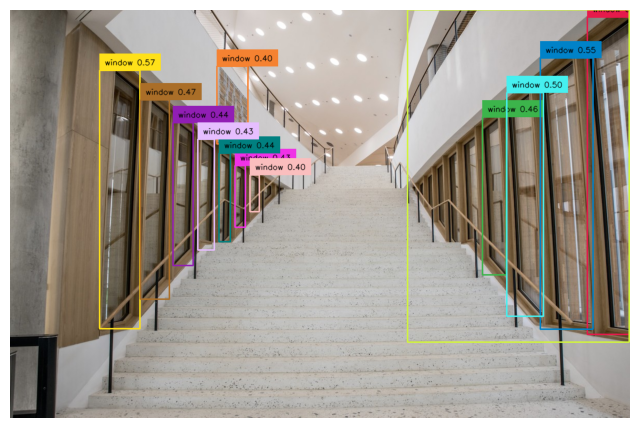

In [ ]:
os.system('wget -q https://github.com/ol3gka/Advanced-training-course-Fundamentals-of-computer-vision-Skoltech-/blob/main/hw_1/pictures/skoltech.jpeg?raw=true')
os.rename('skoltech.jpeg?raw=true', 'skoltech.jpeg')
image_source, image = load_image('skoltech.jpeg')
boxes, logits, phrases = run_dino(dino, image, text_prompt='window')

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
sv.plot_image(annotated_frame, (8, 8))

## 3. Upload custom dataset (3 points)

In [ ]:
data = load_dataset('beans')
data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

In [ ]:
def annotate(dino, data, data_size, data_dir):
    data = data.train_test_split(train_size=min(len(data), data_size))['train']
    image_dir = f'{data_dir}/images'
    label_dir = f'{data_dir}/labels'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    for i, d in enumerate(tqdm(data)):
        image_path = f'{image_dir}/{i:06d}.png'
        label_path = f'{label_dir}/{i:06d}.txt'
        image = d['image'].resize((640, 640))
        image.save(image_path)
        image_source, image = load_image(image_path)
        boxes, logits, phrases = run_dino(dino, image)
        label = ['0 ' + ' '.join(list(map(str, b))) for b in boxes.tolist()]
        label = '\n'.join(label)
        with open(label_path, 'w') as f:
            f.write(label)

annotate(dino, data['train'], 500, 'data/train') # 500
annotate(dino, data['validation'], 20, 'data/validation') # 20

config = {
    'names': ['beans'],
    'nc': 1,
    'train': 'train/images',
    'val': 'validation/images'
}

with open('data/data.yaml', 'w') as f:
    yaml.dump(config, f)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

## 4. Fine-tune YOLOv8 (3 points)

Дообучим YOLOv8 на датасете с людьми в масках
данные взяты из huggingface


Фото для инференса для недообученой модели взято из статьи (см. ниже):
https://www.cnbc.com/2022/12/05/cdc-encourages-people-to-wear-masks-to-prevent-spread-of-covid-flu-rsv.html

In [ ]:
yolo = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 303MB/s]


In [ ]:
# # Делаем инференс на недообученной модели
os.system('wget -q https://github.com/ol3gka/Advanced-training-course-Fundamentals-of-computer-vision-Skoltech/blob/main/hw_1/pictures/bean_rust.jpg?raw=true')
os.rename('bean_rust.jpg?raw=true', 'bean_rust.jpg')


yolo.predict("bean_rust.jpg")


image 1/1 /content/bean_rust.jpg: 640x640 1 umbrella, 1 cake, 12.4ms
Speed: 7.5ms preprocess, 12.4ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [ ]:
# Дообучаем модель
yolo.train(data='/content/data/data.yaml', epochs=5, device='0', save=True)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fal

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b0520375ba0>
fitness: 0.482332518358965
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.46585])
names: {0: 'beans'}
plot: True
results_dict: {'metrics/precision(B)': 0.593758976367672, 'metrics/recall(B)': 0.7314719610915263, 'metrics/mAP50(B)': 0.6306903348416287, 'metrics/mAP50-95(B)': 0.4658483165275579, 'fitness': 0.482332518358965}
save_dir: PosixPath('runs/detect/train')
speed: {'preprocess': 0.20170211791992188, 'inference': 3.2788634300231934, 'loss': 0.0010013580322265625, 'postprocess': 1.7003059387207031}

In [ ]:
valid_results = yolo.val()
print(valid_results)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/data/validation/labels.cache... 20 images, 6 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]
                   all         20         16      0.594      0.732      0.631      0.466
Speed: 15.9ms preprocess, 23.3ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b051fe8d420>
fitness: 0.48236172041847447
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.46587])
names: {0: 'beans'}
plot: True
results_dict: {'metrics/precision(B)': 0.5939171002537516, 'metrics/recall(B)': 0.7319413913783249, 'metrics/mAP50(B)': 0.6307628353739625, 'metrics/mAP50-95(B)': 0.4658727076456425, 'fitness': 0.48236172041847447}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 15.938496589660643, 'inference': 23.256802558898926, 'loss': 0.002288818359375, 'postprocess': 6.460165977478027}


## 5. Visualize results (3 points)

In [ ]:
def run_yolo(yolo, image_url, conf=0.25, iou=0.7):
    results = yolo(image_url, conf=conf, iou=iou)
    res = results[0].plot()[:, :, [2,1,0]]
    return Image.fromarray(res)
# !!!!!
yolo = YOLO('runs/detect/train/weights/best.pt')


image 1/1 /content/bean_rust.jpg: 640x640 1 beans, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


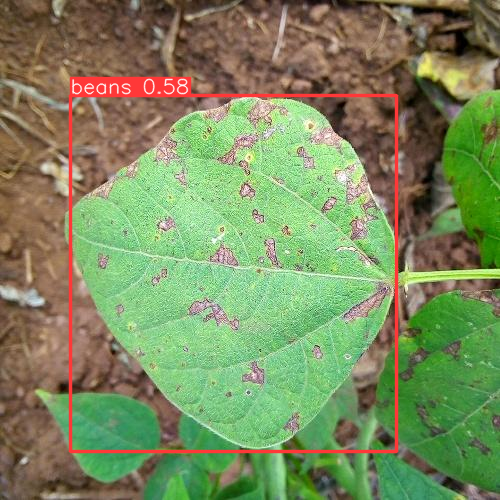

In [ ]:
image_url = "bean_rust.jpg"
run_yolo(yolo, image_url)

В результате выполнения домашнего задания, были ролучены следующие результаты:

1) Загружен кастомный датасет (листья)

2) Дообучена модель YOLOv8 (5 эпох)

3) Визиализированы результаты (пример детектирования листочка)